In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
import cupy as cp
from keras.layers import LSTM
from  tensorflow.keras.layers import LSTM,Dense,Activation,Dropout
from  tensorflow.keras.callbacks import History,Callback,EarlyStopping
import os
import tensorflow as tf
import datetime
import h5py

In [2]:
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/trainX400.h5', 'r')
trainX = f['data']
trainX  = cp.array(trainX)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/trainY400.h5', 'r')
trainY = f['data']
trainY  = cp.array(trainY)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/testX400.h5', 'r')
testX = f['data']
testX  = cp.array(testX)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/testY400.h5', 'r')
testY = f['data']
testY  = cp.array(testY)
f.close()
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(406800, 24, 3)
(406800, 3)
(169200, 24, 3)
(169200, 3)


In [3]:
#选择要测试kpi sms=0 call=1 internet=2
kpi=0
if kpi==0:
    kpi_name='sms'
elif kpi==1:
    kpi_name='call'
else:
    kpi_name='internet'

In [4]:
#查找每个kpi最大值
trainmax=[int(cp.max(trainX[:,:,0])),int(cp.max(trainX[:,:,1])),int(cp.max(trainX[:,:,2]))]
testmax=[int(cp.max(testX[:,:,0])),int(cp.max(testX[:,:,1])),int(cp.max(testX[:,:,2]))]
print(trainmax)
print(testmax)


[4047, 3417, 23564]
[10118, 3815, 20809]


In [5]:
#归一化
for i in range(3):
    trainX[:,:,i] = trainX[:,:,i]/trainmax[i]
    testX[:,:,i] = testX[:,:,i]/testmax[i]
    trainY[:,i] = trainY[:,i]/trainmax[i]

In [6]:
trainX = cp.reshape(trainX[:,:,kpi], (trainX.shape[0],trainX.shape[1], 1))
testX = cp.reshape(testX[:,:,kpi], (testX.shape[0],testX.shape[1],1))
trainY = cp.reshape(trainY[:,kpi], (trainY.shape[0], 1))
testY = cp.reshape(testY[:,kpi], (testY.shape[0], 1))
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(406800, 24, 1)
(169200, 24, 1)
(406800, 1)
(169200, 1)


In [9]:
model = Sequential()
model.add(LSTM(60,input_shape=(trainX.shape[1],trainX.shape[2]),
                   return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(60,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(trainY.shape[1]))
model.add(Activation("relu"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 24, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 43,981
Trainable params: 43,981
Non-traina

In [10]:


cbs = [History(), EarlyStopping(monitor='val_loss',
                                patience=10,
                                min_delta=0.00001,
                                verbose=0)]
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+kpi_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history=model.fit(trainX.get(),
        trainY.get(),
        batch_size=64,
        epochs=200,
        validation_split=0.2,
        callbacks=[cbs,tensorboard_callback],
        verbose=True)
model.save(os.path.join(f"D:\library\Github\Innovative-practice\第三学期\DATA\lstm",f"Test_{kpi_name}400_1" + ".h5"))

Epoch 1/200
5085/5085 [==============================] - 70s 12ms/step - loss: 4.2851e-04 - accuracy: 6.6679e-04 - val_loss: 2.0982e-04 - val_accuracy: 0.0028
Epoch 2/200
5085/5085 [==============================] - 57s 11ms/step - loss: 3.0806e-04 - accuracy: 6.6679e-04 - val_loss: 1.9520e-04 - val_accuracy: 0.0028
Epoch 3/200
5085/5085 [==============================] - 58s 11ms/step - loss: 2.9216e-04 - accuracy: 6.6679e-04 - val_loss: 2.0093e-04 - val_accuracy: 0.0028
Epoch 4/200
5085/5085 [==============================] - 57s 11ms/step - loss: 2.7513e-04 - accuracy: 6.6679e-04 - val_loss: 1.8132e-04 - val_accuracy: 0.0028
Epoch 5/200
5085/5085 [==============================] - 59s 12ms/step - loss: 2.6085e-04 - accuracy: 6.6679e-04 - val_loss: 1.6859e-04 - val_accuracy: 0.0028
Epoch 6/200
5085/5085 [==============================] - 56s 11ms/step - loss: 2.4659e-04 - accuracy: 6.6679e-04 - val_loss: 1.6565e-04 - val_accuracy: 0.0028
Epoch 7/200
5085/5085 [=======================

In [20]:
#读取训练时的loss
%tensorboard --logdir D:\library\Github\Innovative-practice\第三学期\lstm\logs\fit

UsageError: Line magic function `%tensorboard` not found.


In [7]:
#预测
model = load_model(os.path.join(f"D:\library\Github\Innovative-practice\第三学期\lstm\DATA\lstm",f"Test_{kpi_name}400_1" + ".h5"))
trainPredict = model.predict(trainX.get())
testPredict = model.predict(testX[:].get())

print(trainPredict.shape)
print(testPredict.shape)



5288/5288 [==============================] - 25s 5ms/step
(406800, 1)
(169200, 1)


In [8]:
testPredict = testPredict
testY = testY.get()

In [13]:
from scipy.stats import kstest
import pandas as pd
import numpy as np
def KsNormDetect(data):
    # 计算均值
    u = data.mean()
    # 计算标准差
    std = data.std()
    # 计算P值
    res=kstest(data, 'norm', (u, std))[1]
    # 判断p值是否服从正态分布，p<=0.05 则服从正态分布，否则不服从。
    if res<=0.05:
        #print('该列数据服从正态分布------------')
        #print('均值为：%.3f，标准差为：%.3f' % (u, std))
        #print('------------------------------')
        return 1
    else:
        return 0



def OutlierDetection(data,ks_res):
    # 计算均值
    u =data.mean()
    # 计算标准差
    std = data.std()
    if ks_res==1:
        # 定义3σ法则识别异常值
        # 识别异常值
        error_y = [i for i in data if abs(i-u)> 3 * std]
        # 识别异常值的索引
        error_index = [i for i in range(len(data)) if abs(data[i]-u)> 3 * std]
        #error_y转变为一行int列表
        error_y = [int(i) for i in error_y]
        return error_y,error_index

    else:
        print('请先检测数据是否服从正态分布-----------')
        return [],[]





In [9]:
residual=abs(testPredict*testmax[kpi]-testY)
testPredict1=testPredict*testmax[kpi]
#查看residual类型
print(type(residual))


<class 'numpy.ndarray'>


In [ ]:
import matplotlib.pyplot as plt
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

for i in range(50):
    data = residual[i*423:(i+1)*423]
    ks_res=KsNormDetect(data)
    error_y,error_index=OutlierDetection(data, ks_res)
    error_index_testY=[j+i*423 for j in error_index]
    plt.figure( figsize=(100,10) )
    plt.subplot(2,1,1)
    plt.plot(testY[i*423:(i+1)*423])
    plt.plot(testPredict[i*423:(i+1)*423]*testmax[kpi])
    #error_index用取出testY中的异常值
    plt.scatter(error_index,testY[error_index_testY],c='r',linewidths=25)
    plt.title(f"{kpi_name}测试集预测图{i}",fontsize=50)
    plt.legend(['Ground Truth',"LSTM"],fontsize=50)
    plt.subplot(2,1,2)
    plt.plot(abs(testY[i*423:(i+1)*423]-testPredict[i*423:(i+1)*423]*testmax[kpi]))
    plt.scatter(error_index,error_y,c='r',linewidths=25)
    plt.title(f"{kpi_name}测试集误差图{i}",fontsize=50)
    plt.savefig(f'D:\library\Github\Innovative-practice\第三学期\DATA\pic\lstm\pred400\{kpi_name}\{kpi_name}测试集预测图{i}.png')
    plt.close()
   

In [16]:
#保存testY和testPredict到h5文件
'''import h5py
f2.close()
f2=h5py.File(f'D:\library\Github\Innovative-practice\第三学期\DATA\pic\lstm\smstestYandtestpred.h5','w')
f2.create_dataset('testY',data=testY)
f2.create_dataset('testPredict',data=testPredict1)
f2.close()'''


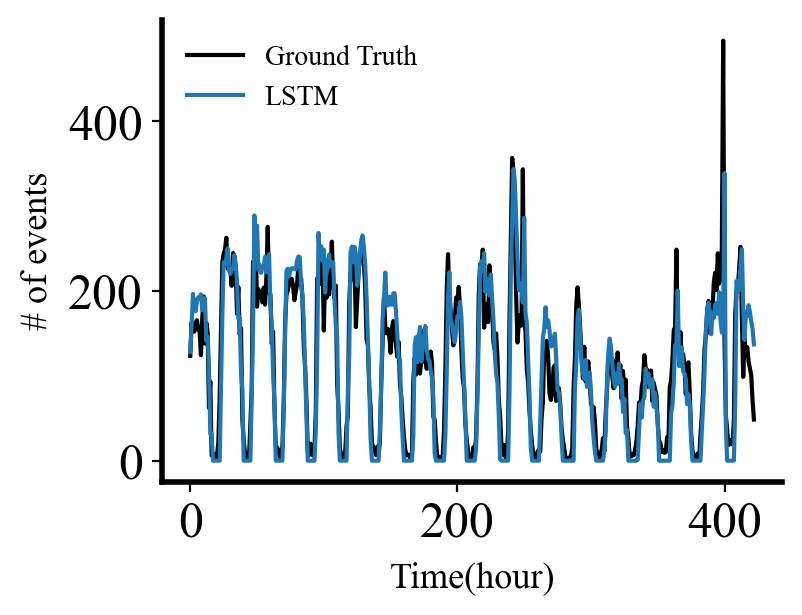

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
# 可视化绘制
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time(hour)', fontsize=13,labelpad=5)
ax.set_ylabel('# of events', fontsize=13,labelpad=5)
ax.plot(testY[15*423:(15+1)*423],label='Ground Truth',color='black')
ax.plot(testPredict[15*423:(15+1)*423]*testmax[kpi],label='LSTM')
ax.legend(fontsize=10,loc='upper left',frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


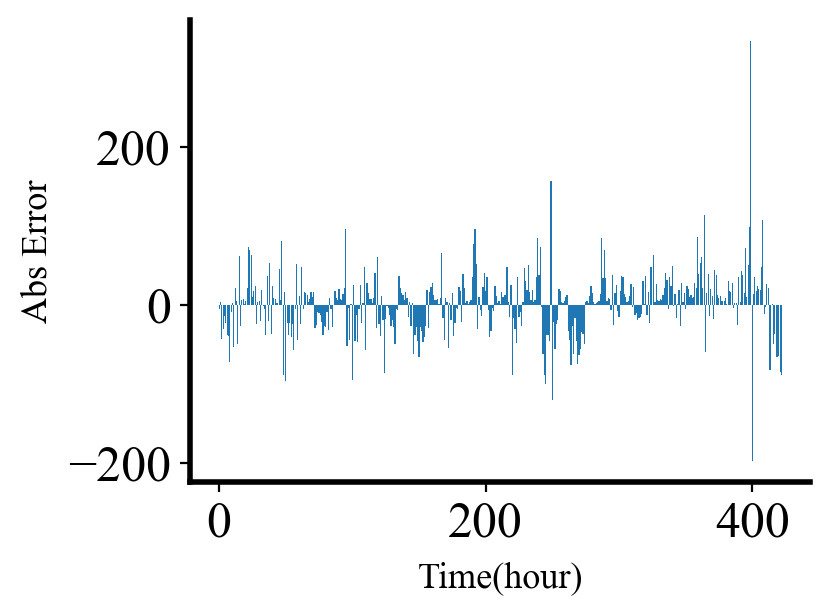

In [40]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
# 可视化绘制
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time(hour)', fontsize=13,labelpad=5)
ax.set_ylabel('Abs Error', fontsize=13,labelpad=5)
data=(testY[15*423:(15+1)*423]-testPredict[15*423:(15+1)*423]*testmax[kpi])
#data转换为一维数组
data=data.reshape(1,-1)[0]
#绘制误差条形图
ax.bar(range(423),data)
ax.legend(fontsize=10,loc='upper left',frameon=False)

In [42]:
from  sklearn import  metrics
import numpy as np

def GetRMSE(y_hat,y_test):
    sum = np.sqrt(metrics.mean_squared_error(y_test, y_hat))
    return  sum

def GetMAE(y_hat,y_test):
    sum = metrics.mean_absolute_error(y_test, y_hat)
    return  sum

def GetMAPE_Order(y_hat,y_test):
    #删除test_y 为0元素
    zero_index = np.where(y_test == 0)
    y_hat = np.delete(y_hat,zero_index[0])
    y_test = np.delete(y_test,zero_index[0])
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum
#计算R2
def GetR2(y_hat,y_test):
    sum = metrics.r2_score(y_test, y_hat)
    return sum
print(type(testY))



print("RMSE为",GetRMSE(testPredict1,testY))
print("MAE为",GetMAE(testPredict1,testY))
print("MAPE为",GetMAPE_Order(testPredict1,testY))
print("R2为",GetR2(testPredict1,testY))


<class 'numpy.ndarray'>
RMSE为 77.09328332548968
MAE为 37.723138796599756
MAPE为 59.56432000562807
R2为 0.8631318383867778
